<a href="https://colab.research.google.com/github/SMunira38/WASTE/blob/main/waste1_train_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import math
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tabulate import tabulate
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
# Path to your combined_dataset
combined_path = "/content/drive/MyDrive/combined_dataset"

# Function to count images in each category
def count_images_in_combined_dataset():
    total_images = {}
    if os.path.exists(combined_path):
        for category in os.listdir(combined_path):
            category_path = os.path.join(combined_path, category)
            if os.path.isdir(category_path):
                total_images[category] = len(os.listdir(category_path))
    return total_images

# Get the total count of images in each category
image_counts = count_images_in_combined_dataset()

# Print the results
for category, count in image_counts.items():
    print(f"Total images in '{category}': {count}")

# Total images in the entire combined dataset
total_images = sum(image_counts.values())
print(f"Total images in combined_dataset: {total_images}")


Total images in 'Biodegradable Waste': 5796
Total images in 'Non-Biodegradable Waste': 4404
Total images in combined_dataset: 10200


In [6]:
# Define dataset path
data_dir = '/content/drive/MyDrive/combined_dataset'  # Your dataset path
batch_size = 64

# Define transformations (no resizing needed)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define proportions
test_proportion = 0.15
val_proportion = 0.15

# Get indices for each class
biodegradable_indices = [i for i in range(len(dataset)) if dataset.targets[i] == 0]
non_biodegradable_indices = [i for i in range(len(dataset)) if dataset.targets[i] == 1]

# Function to split dataset
def split_data(indices, test_ratio, val_ratio):
    random.shuffle(indices)
    total_samples = len(indices)

    test_size = math.floor(test_ratio * total_samples)
    val_size = math.floor(val_ratio * total_samples)

    test_data = indices[:test_size]
    val_data = indices[test_size:(test_size + val_size)]
    train_data = indices[(test_size + val_size):]

    return train_data, val_data, test_data

# Split data for both classes
train_bio, val_bio, test_bio = split_data(biodegradable_indices, test_proportion, val_proportion)
train_nonbio, val_nonbio, test_nonbio = split_data(non_biodegradable_indices, test_proportion, val_proportion)

# Merge train, val, and test indices
train_indices = train_bio + train_nonbio
val_indices = val_bio + val_nonbio
test_indices = test_bio + test_nonbio

# Create subset datasets
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

# Print dataset statistics
print("Class-wise Data Distribution:")
table_data = [
    ["Biodegradable", len(train_bio), len(val_bio), len(test_bio)],
    ["Non-Biodegradable", len(train_nonbio), len(val_nonbio), len(test_nonbio)]
]

# Display class-wise sample distribution
headers = ["Class", "Train Samples", "Validation Samples", "Test Samples"]
print(tabulate(table_data, headers, tablefmt='grid'))


Class-wise Data Distribution:
+-------------------+-----------------+----------------------+----------------+
| Class             |   Train Samples |   Validation Samples |   Test Samples |
+===================+=================+======================+================+
| Biodegradable     |            4058 |                  869 |            869 |
+-------------------+-----------------+----------------------+----------------+
| Non-Biodegradable |            3084 |                  660 |            660 |
+-------------------+-----------------+----------------------+----------------+


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50 model with pretrained weights
model = models.resnet50(weights='IMAGENET1K_V1')  # Change to 'DEFAULT' if using older PyTorch versions
model.fc = nn.Linear(model.fc.in_features, 2)  # Change the final layer to match the number of classes
model = model.to(device)  # Move model to GPU or CPU

# Freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze the last convolutional block
for param in model.layer4.parameters():  # Unfreeze layer4
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Only optimize parameters that are trainable


In [10]:
# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# TRAINING PHASE
for epoch in range(num_epochs):
    model.train()  # Set to training mode
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    # Compute train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions_train / total_samples_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy * 100)  # Store in percentage

    # VALIDATION PHASE
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    # Compute validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_predictions_val / total_samples_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy * 100)  # Store in percentage

    print(f"Epoch [{epoch + 1}/{num_epochs}] | "
          f"Train Acc: {train_accuracy * 100:.2f}% | Train Loss: {train_loss:.6f} | "
          f"Val Acc: {val_accuracy * 100:.2f}% | Val Loss: {val_loss:.6f}")

print("\nTraining Finished ✅\n")

Epoch [1/10] | Train Acc: 97.73% | Train Loss: 0.058525 | Val Acc: 99.87% | Val Loss: 0.014266
Epoch [2/10] | Train Acc: 99.86% | Train Loss: 0.006371 | Val Acc: 99.67% | Val Loss: 0.011894
Epoch [3/10] | Train Acc: 99.89% | Train Loss: 0.003711 | Val Acc: 99.48% | Val Loss: 0.018215
Epoch [4/10] | Train Acc: 99.94% | Train Loss: 0.003514 | Val Acc: 100.00% | Val Loss: 0.000433
Epoch [5/10] | Train Acc: 99.92% | Train Loss: 0.002530 | Val Acc: 98.30% | Val Loss: 0.072998
Epoch [6/10] | Train Acc: 99.96% | Train Loss: 0.002763 | Val Acc: 100.00% | Val Loss: 0.000611
Epoch [7/10] | Train Acc: 99.92% | Train Loss: 0.003149 | Val Acc: 96.47% | Val Loss: 0.239924
Epoch [8/10] | Train Acc: 99.50% | Train Loss: 0.014856 | Val Acc: 100.00% | Val Loss: 0.001601
Epoch [9/10] | Train Acc: 99.90% | Train Loss: 0.002600 | Val Acc: 99.93% | Val Loss: 0.003054
Epoch [10/10] | Train Acc: 99.82% | Train Loss: 0.004245 | Val Acc: 99.87% | Val Loss: 0.003065

Training Finished ✅



In [11]:
# TESTING PHASE (Only After Training)
test_accuracies = []
model.eval()  # Set model to evaluation mode
correct_predictions_test = 0
total_samples_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

# Compute final test accuracy
test_accuracy = correct_predictions_test / total_samples_test
test_accuracies.append(test_accuracy)

print(f"Test Accuracy: {test_accuracy * 100:.2f}% 🎯")


Test Accuracy: 99.87% 🎯


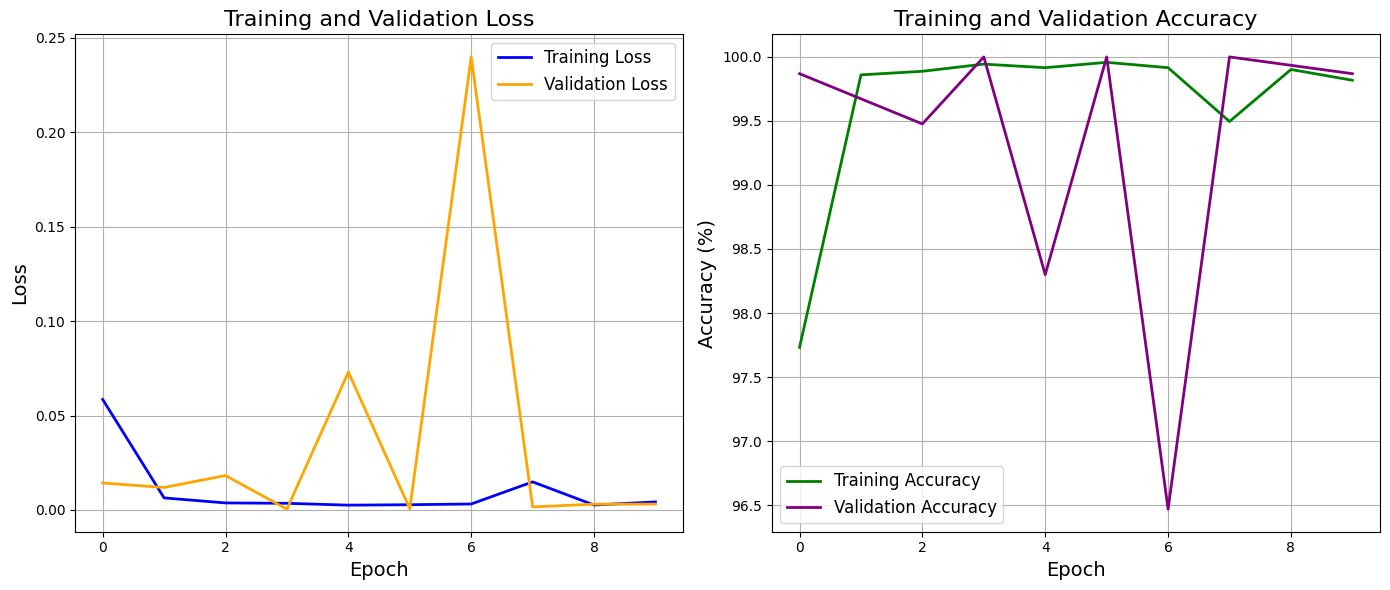

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', color='purple', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


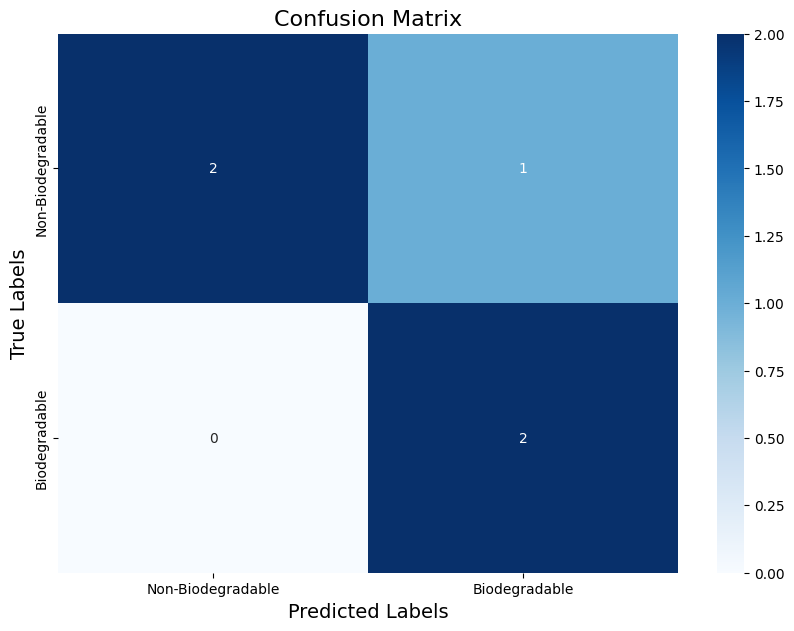

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have true labels and predicted labels from your model
# Replace these lines with your actual data
true_labels = np.array([0, 1, 0, 1, 0])  # Example true labels (replace with actual)
predicted_labels = np.array([0, 1, 1, 1, 0])  # Example predictions (replace with actual)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Biodegradable', 'Biodegradable'],
            yticklabels=['Non-Biodegradable', 'Biodegradable'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tabulate import tabulate

# TESTING PHASE (Only After Training)
test_accuracies = []
model.eval()  # Set model to evaluation mode
correct_predictions_test = 0
total_samples_test = 0

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Append true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute final test accuracy
test_accuracy = correct_predictions_test / total_samples_test
test_accuracies.append(test_accuracy)

print(f"Test Accuracy: {test_accuracy * 100:.2f}% 🎯")

# Calculate classification report for precision, recall, and F1-score
class_report = classification_report(true_labels, predicted_labels, target_names=dataset.classes, output_dict=True)

# Print overall metrics
overall_precision = class_report['weighted avg']['precision'] * 100
overall_recall = class_report['weighted avg']['recall'] * 100
overall_f1_score = class_report['weighted avg']['f1-score'] * 100
overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100

print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1-Score: {overall_f1_score:.2f}%")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 99.87% 🎯
Overall Precision: 99.87%
Overall Recall: 99.87%
Overall F1-Score: 99.87%
Overall Accuracy: 99.87%


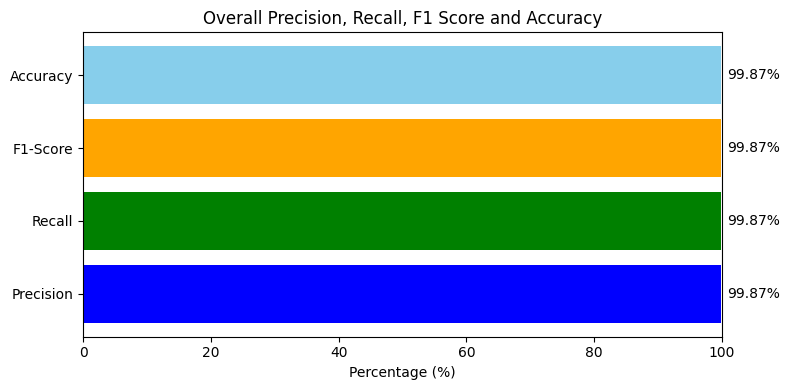

In [21]:
import matplotlib.pyplot as plt

# Create labels and values for the metrics
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
values = [overall_precision, overall_recall, overall_f1_score, overall_accuracy]

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))
plt.barh(metrics, values, color=['blue', 'green', 'orange', 'skyblue'])
plt.xlim(0, 100)  # Set the x-axis limit to 0-100 for percentage values
plt.title('Overall Precision, Recall, F1 Score and Accuracy')
plt.xlabel('Percentage (%)')

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(v + 1, i, f'{v:.2f}%', va='center')

# Show the plot
plt.tight_layout()
plt.show()

